In [1]:
import pandas as pd
import sklearn as sk
import scipy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize 
from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score,plot_confusion_matrix,precision_score,recall_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report




In [24]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('./data/exoTrain.csv')

test = pd.read_csv('./data/exoTest.csv')



In [3]:
train.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


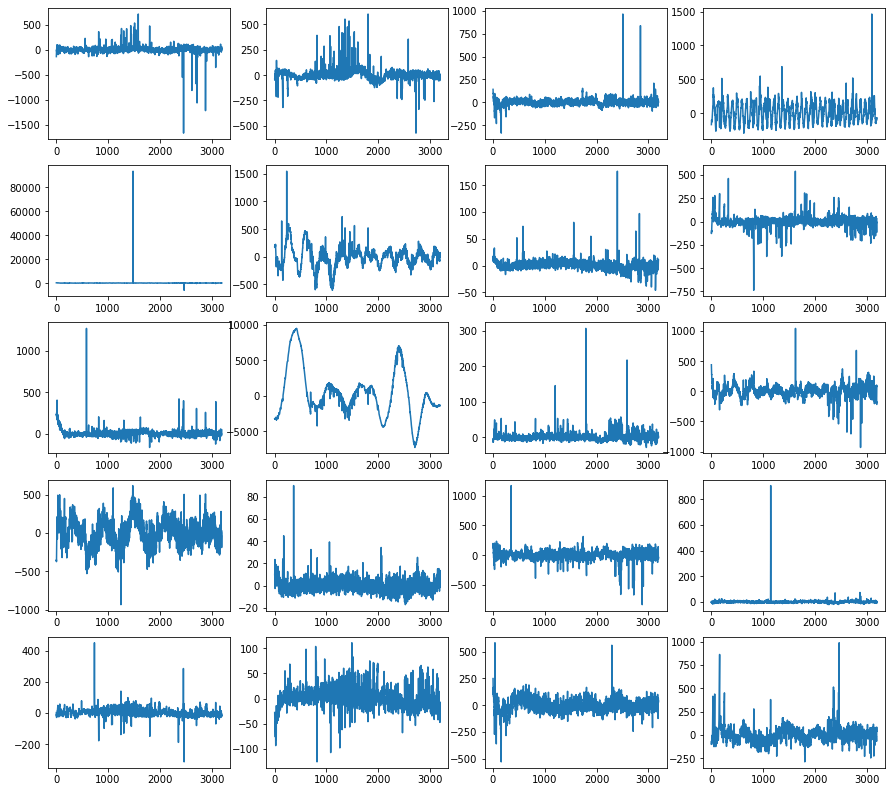

In [6]:
# visualizing non-exoplanet-stars
fig = plt.figure(figsize=(15,40))
x = np.array(range(3197))
for i in range(20):
    ax = fig.add_subplot(14,4,i+1)
    ax.plot(x,train[train.LABEL == 1].iloc[i,1:])





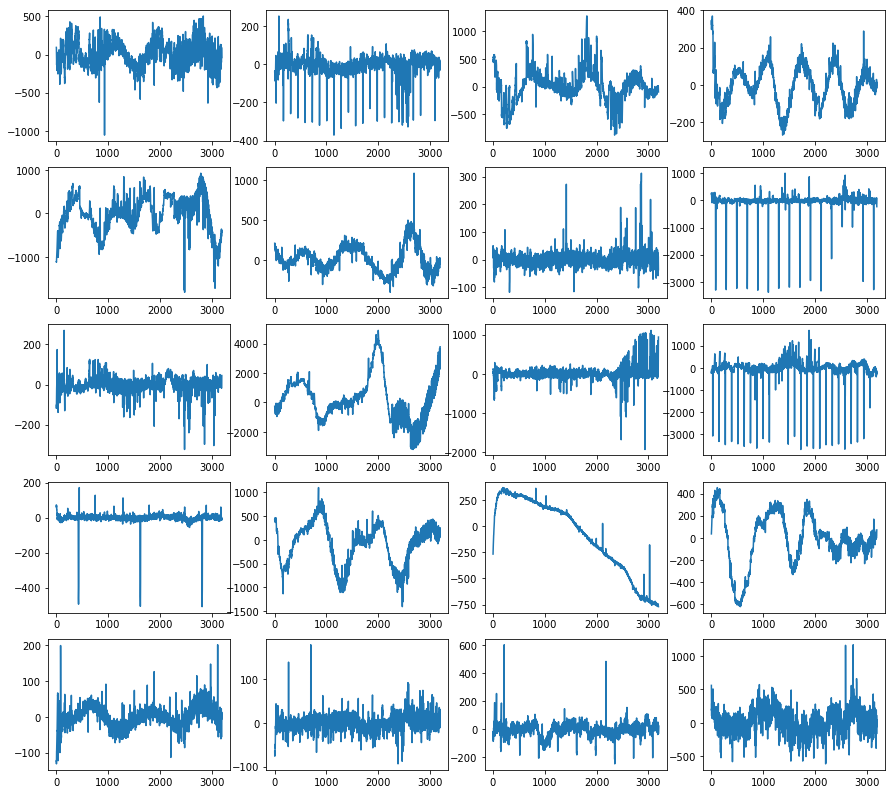

In [7]:
# visualizing exoplanet-stars: trend over time is approximately periodic and outliers are present
fig = plt.figure(figsize=(15,40))
x = np.array(range(3197))
for i in range(20):
    ax = fig.add_subplot(14,4,i+1)
    ax.plot(x,train[train.LABEL == 2].iloc[i,1:])


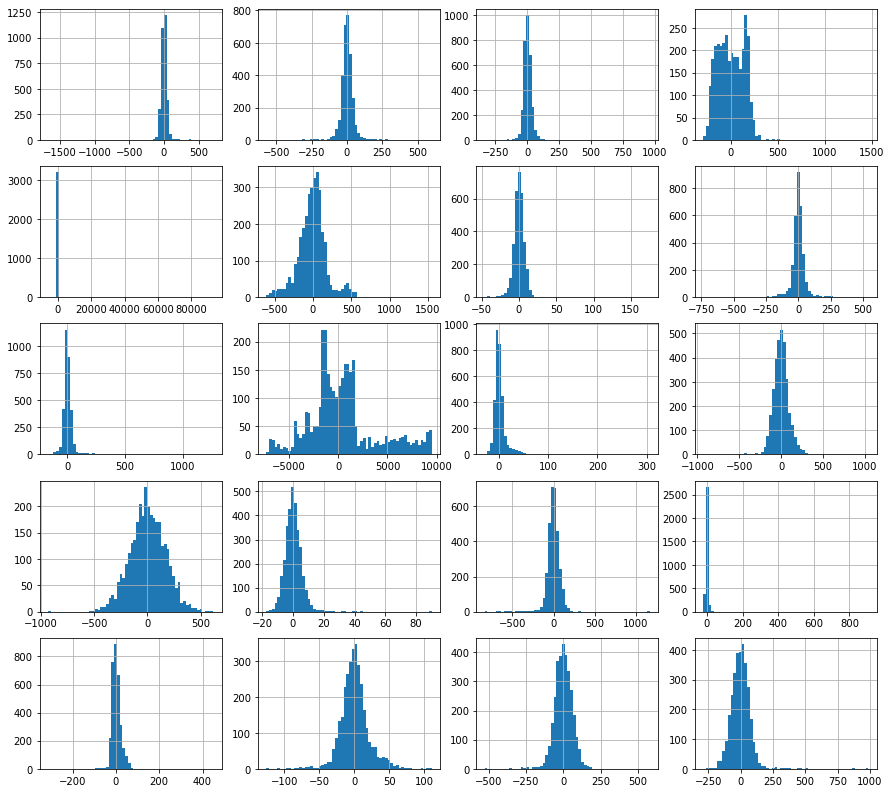

In [8]:
# visualizing flux distribution of non-exoplanet-stars: narrower distribution b/c flux values are more consistent
fig = plt.figure(figsize=(15,40))
for i in range(20):
    ax = fig.add_subplot(14,4,i+1)
    train[train.LABEL ==1].iloc[i,1:].hist(bins=60)


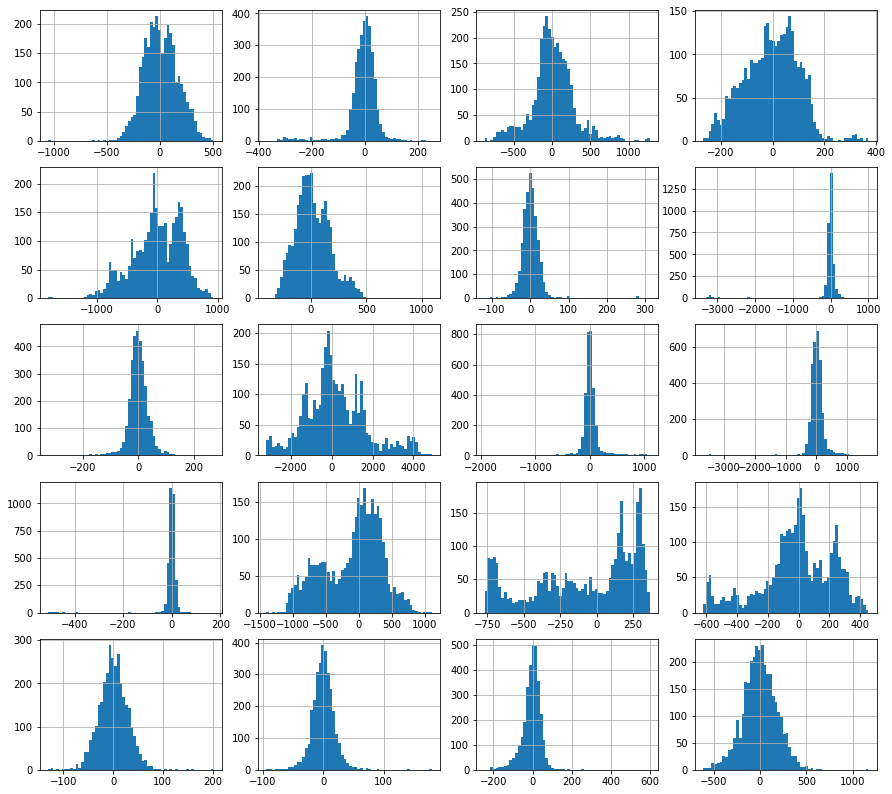

In [9]:
# visualizing flux distribution of exoplanet-stars: wider distribution b/c flux values vary more 
fig = plt.figure(figsize=(15,40))
for i in range(20):
    ax = fig.add_subplot(14,4,i+1)
    train[train.LABEL ==2].iloc[i,1:].hist(bins=60)

In [17]:
from sklearn.model_selection import train_test_split

y_train = train['LABEL']
X_train = train[train.columns[1:]]

y_test = test['LABEL']
X_test = test[train.columns[1:]]
print('LABEL' not in X_train.columns) ## check that we didn't include the labels
print('LABEL' not in X_test.columns) ## check that we didn't include the labels

True
True


In [19]:
# train split
y_train.value_counts()

1    5050
2      37
Name: LABEL, dtype: int64

In [25]:
# baseline model w/o any processing
from sklearn import svm
svm = svm.SVC(kernel = 'rbf')
svm.fit(X_train,y_train)
preds = svm.predict(X_test)
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       565
           2       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



In [26]:
preds_train = svm.predict(X_train)
print(classification_report(y_train,preds_train))

              precision    recall  f1-score   support

           1       0.99      1.00      1.00      5050
           2       0.00      0.00      0.00        37

    accuracy                           0.99      5087
   macro avg       0.50      0.50      0.50      5087
weighted avg       0.99      0.99      0.99      5087



In [27]:
# we will do a heavy amount of feature engineering

In [137]:
y_test.value_counts()

1    565
2      5
Name: LABEL, dtype: int64

In [141]:
from imblearn.over_sampling import SMOTE
from collections import Counter
oversample = SMOTE()
X_sampled, y_sampled = oversample.fit_resample(X_train, y_train)
# summarize the new class distribution
counter = Counter(y_sampled)
print(counter)

Counter({2: 5050, 1: 5050})


In [142]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X_sampled)
X_embedded.shape

(10100, 2)

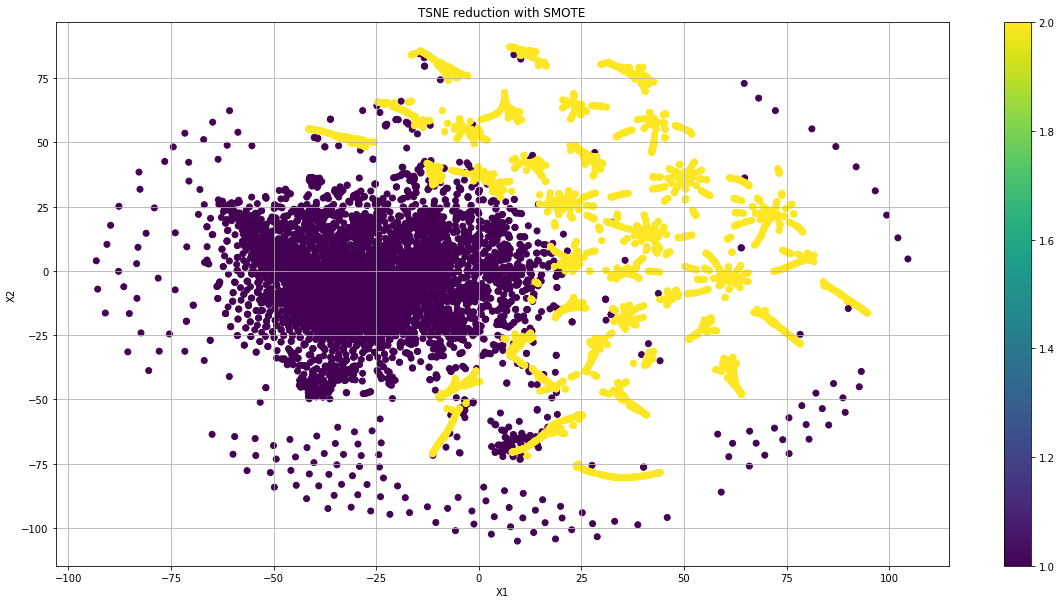

In [143]:
plt.figure(figsize = (20,10))
plt.title('TSNE reduction with SMOTE')
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y_sampled)
plt.colorbar()
plt.grid()
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [144]:
# one can clearly identify the positive samples generated by SMOTE in the tsne reduction

In [145]:
# separate model with processing
from sklearn import svm
svm = svm.SVC(kernel = 'rbf')
svm.fit(X_sampled,y_sampled)
preds = svm.predict(X_test)
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           1       0.99      1.00      0.99       565
           2       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



In [146]:
preds_train = svm.predict(X_sampled)
print(classification_report(y_sampled,preds_train))

              precision    recall  f1-score   support

           1       0.52      1.00      0.68      5050
           2       0.94      0.07      0.13      5050

    accuracy                           0.53     10100
   macro avg       0.73      0.53      0.41     10100
weighted avg       0.73      0.53      0.41     10100



In [147]:
# signal processing
from scipy import fftpack

fs = 3
sample = X_sampled.iloc[1000] 
fft_wave = np.fft.fft(sample)

# Compute the Discrete Fourier Transform sample frequencies.

fft_fre = np.fft.fftfreq(n=sample.shape[0], d=1/fs)

Text(0.5, 1.0, 'FFT in Frequency Domain')

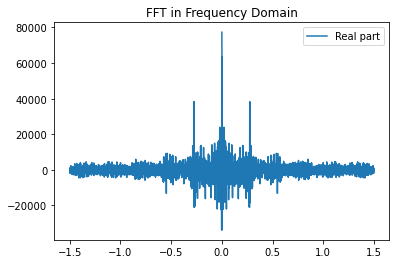

In [148]:
plt.plot(fft_fre, fft_wave.real, label="Real part")

plt.legend(loc=1)
plt.title("FFT in Frequency Domain")

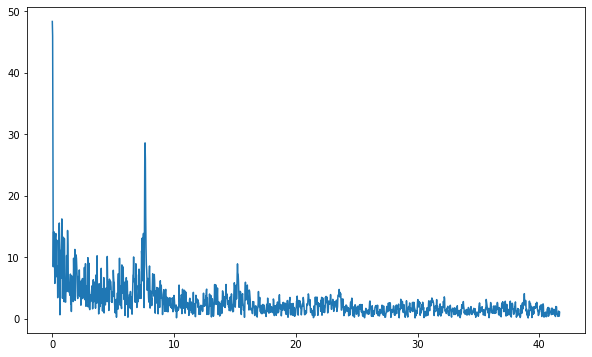

In [149]:
yf = fftpack.fft(sample.values, len(sample))

amp = np.abs(yf) # get amplitude spectrum 
freq = np.linspace(0.0, 1.0/(2.0*(6/500)), len(sample)//2) # get freq axis

# plot the amp spectrum

plt.figure(figsize=(10,6))
plt.plot(freq, (2/amp.size)*amp[0:amp.size//2])
plt.show()

In [152]:
from scipy.signal import detrend

def remove_noise(data):
    import scipy.signal as signal
    N  = 3    
    Wn = 0.15
    B, A = signal.butter(N, Wn, output='ba')
    smooth_data = signal.filtfilt(B,A, data)
    return smooth_data

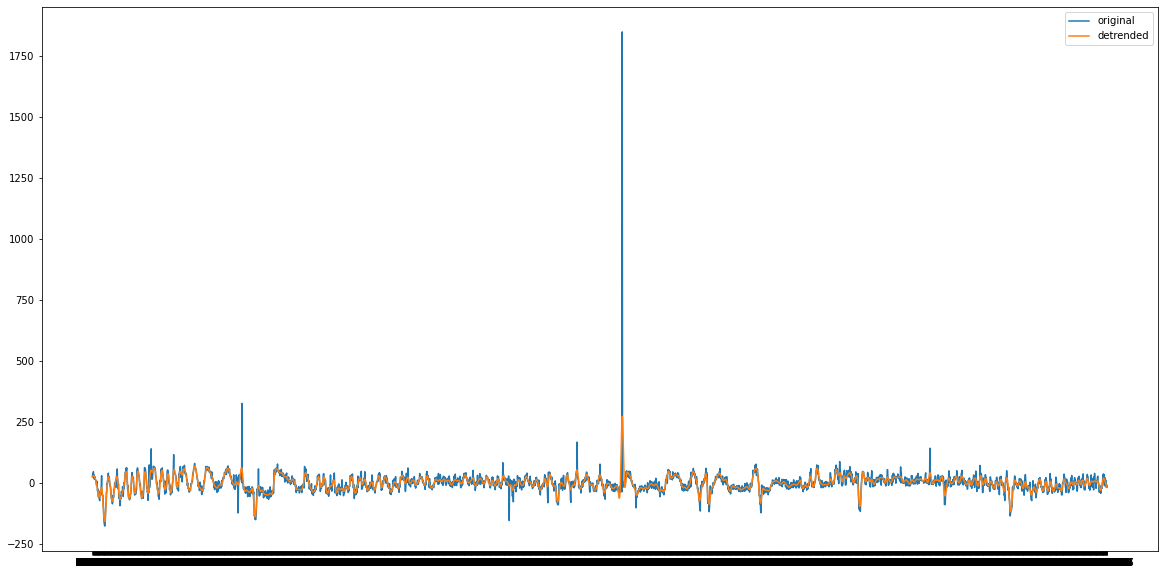

In [153]:
plt.figure(figsize = (20,10))
data = X_train.iloc[32]
smooth_data = remove_noise(data)
plt.plot(data, label = 'original')

plt.plot(smooth_data, label = 'detrended')
plt.legend()

In [154]:
X_transformed  = X_sampled.copy()
for i in range(0, X_sampled.shape[0]):
    data = X_sampled.iloc[i]
    smooth_data = remove_noise(data)
    X_transformed.iloc[i] = smooth_data.T

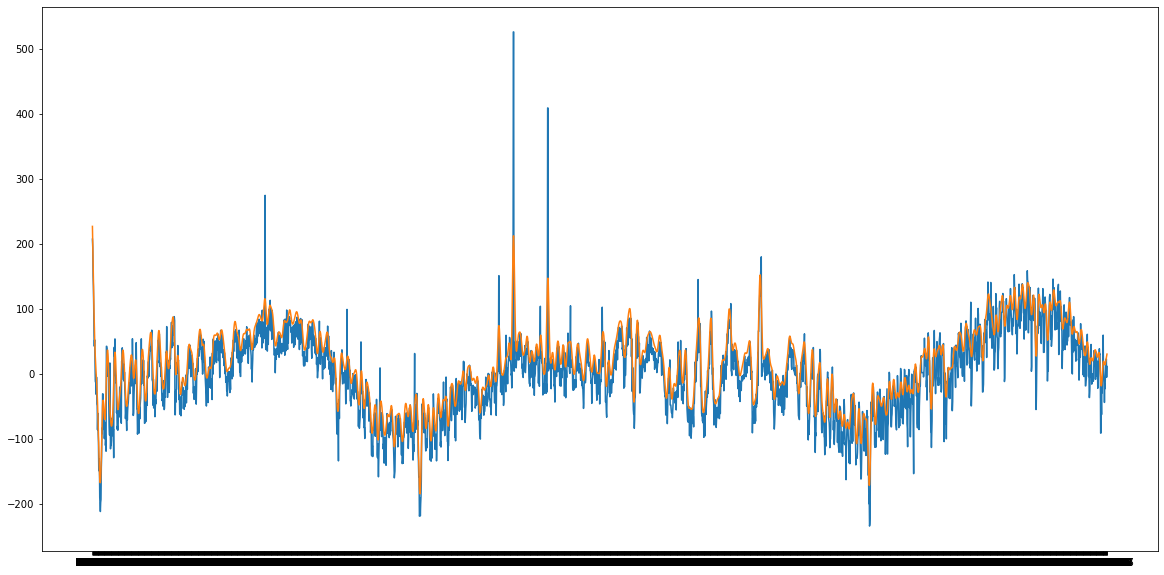

In [155]:
plt.figure(figsize = (20,10))
plt.plot(X_sampled.iloc[24], label = 'original')
plt.plot(X_transformed.iloc[24]+20, label = 'detrended')


In [157]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm




classifier = Pipeline( [('vec', StandardScaler()),
                        ('cls', svm.SVC(kernel = 'rbf'))])


classifier.fit(X_transformed, y_sampled)


# predict the labels of the test data 
preds = classifier.predict(X_test)


In [158]:
print(classification_report(classifier.predict(X_transformed), y_sampled))

              precision    recall  f1-score   support

           1       0.99      0.52      0.68      9641
           2       0.08      0.93      0.15       459

    accuracy                           0.54     10100
   macro avg       0.54      0.72      0.42     10100
weighted avg       0.95      0.54      0.66     10100



In [159]:
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           1       1.00      0.99      0.99       569
           2       0.00      0.00      0.00         1

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       1.00      0.99      0.99       570



In [162]:
Counter(y_sampled)

Counter({2: 5050, 1: 5050})